## Align to Chinook

In [109]:
import pysam
import os.path
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [110]:
chin_ex = pd.read_excel(os.path.join('data','ref','chinook','Supplemental Table 1.xlsx'))
chin_ex.head()

,Locus,Chromosome,Duplicate,Arm,Position (cM),Region of population divergence,Paired-end annotation,Locus name from Larson et al. 2014,Outlier from Larson et al. 2014,Consensus Sequence
0,44207_x1,Ots01,1,p,0.00,0,NaN,NaN,NaN,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...
1,28051_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...
2,6689_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...
3,59778_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...
4,38781_x1,Ots01,1,p,0.55,0,PRTG,NaN,NaN,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...


In [111]:
chin_ex = chin_ex[['Locus', 'Consensus Sequence', 'Chromosome', 'Position (cM)']]
chin_ex['Locus_basename'] = [xx.split('_')[0] for xx in chin_ex['Locus'] ]
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781


drop duplicates, checking with locus basename and sequence

In [112]:
chin_ex.drop_duplicates(subset = ['Locus_basename', 'Consensus Sequence'], inplace = True)

check that each locus is now present only once

In [113]:
len(set(chin_ex['Locus_basename'])) == len(chin_ex['Locus_basename'])

True

In [114]:
with open(os.path.join('data','ref','chinook','chin_ref.fasta'), 'w') as OUTFILE:
    count = 0
    for index,  locus_row in chin_ex.iterrows():
        
        OUTFILE.write('>{}\n{}\n'.format(locus_row['Locus_basename'], locus_row['Consensus Sequence']))

### Align chum loci to chinook loci using bowtie 2 

In [115]:
chin_FASTA = 'chin_ref.fasta'

In [116]:
print('bowtie2-build {} chinook'.format(chin_FASTA))

bowtie2-build chin_ref.fasta chinook


chum ref

In [117]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

align

In [118]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.filtered.SAM'

run bowtie 2

check directories here

In [119]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM


#### Examine reference

In [120]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

In [121]:
### Mapping quality

In [122]:
mpqs = [read.mapping_quality for read in get_aligns()]

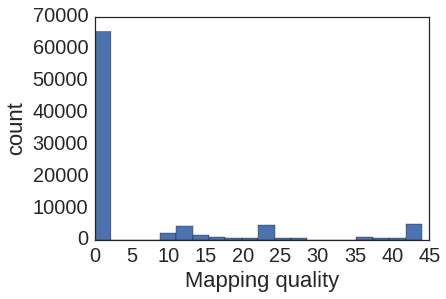

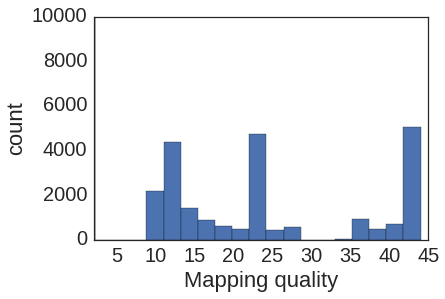

In [123]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.xlim(2)
plt.ylim(0, 10000)
plt.show()

### As expected, there is strand bias

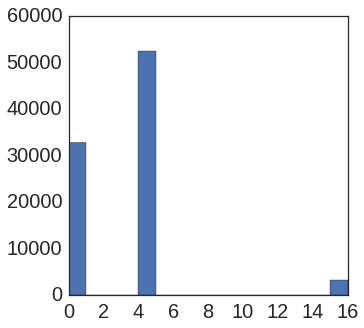

In [124]:
flags  = [read.flag for read in get_aligns()]
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

### Alignment lengths

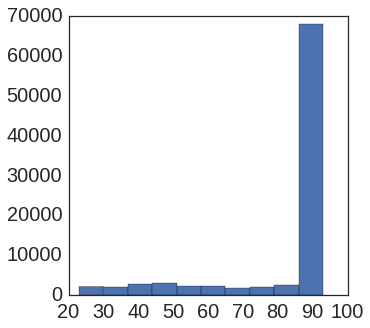

In [125]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

### Edit distances

In [126]:
edit_distances = list()
mq = list()
for read in get_aligns():
    try:
        edit_distances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

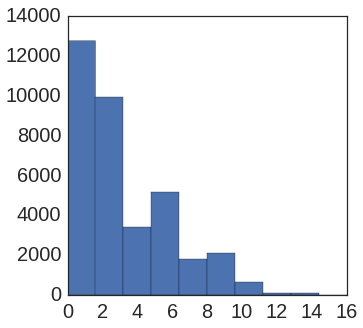

In [127]:
plt.hist(edit_distances)
plt.show()

### Edit distance vs Mapping quality

In [128]:
rr = pd.DataFrame({'ed' : edit_distances, 'mq' : mq })

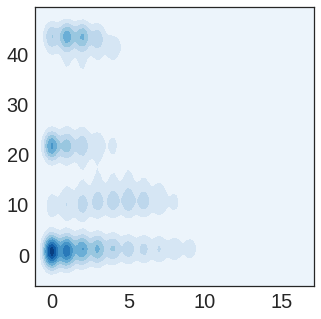

In [129]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length >= 93) AND (mapping_quality >= 30)

In [130]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

In [131]:
filtered_SAM = pd.read_csv(filtered_SAM_output, sep = '\t', comment='@', engine='python', 
            names = ['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','ISIZE','SEQ','QUAL',
                     'TAG1', 'TAG2', 'TAG3' 'TAG4', 'TAG5', 'TAG6', 'TAG7','TAG8', 'TAG9','TAG10'])
filtered_SAM.head()

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,ISIZE,SEQ,QUAL,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,1,44,93M,*,0,0,TGCAGGTACTGCCTCTGCTTGGGCAGCCGCGGGGTCATCAGAGGGC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,1,42,93M,*,0,0,TGCAGGCTGTGTCAGTTCATGAAGAACTACCTGCCCCGGGACTTCA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,1,44,93M,*,0,0,TGCAGGAATATGAGAGGTTGTTCCAAATACAACTGTCTTTTCTGTT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,1,44,93M,*,0,0,TGCAGGTTGTCCACCCTGGAGATGCAGTTCCCTGCCAGGTTCAACA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,1,41,25M4I64M,*,0,0,TGCAGGTAACCACTAAAACCATGACCACACACACACACACAACCAA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


In [132]:
filtered_SAM.drop(['POS', 'RNEXT', 'PNEXT', 'ISIZE', 'SEQ','QUAL'], axis=1, inplace=True)
filtered_SAM['RNAME'] = [str(xx) for xx in filtered_SAM['RNAME'] ]
filtered_SAM.head()

,QNAME,FLAG,RNAME,MAPQ,CIGAR,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,44,93M,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,42,93M,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,44,93M,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,44,93M,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,41,25M4I64M,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


### Now merge with chum and chinook maps

In [133]:
lep_v_pop = pd.read_csv('/home/ipseg/Desktop/waples/chum_populations/data/batch_4/lep_v_pop.txt', sep = '\t')
lep_v_pop.head()

,stacks_SNP,contig,LEP_LG
0,7_74,c1000,11
1,7_92,c1000,11
2,68651_80,c10001,10
3,68651_91,c10001,10
4,2_78,c10003,19


In [134]:
chin_lgs = pd.merge(filtered_SAM, chin_ex, left_on = 'RNAME' , right_on = 'Locus_basename')
synteny = pd.merge(lep_v_pop, chin_lgs, left_on = 'contig' , right_on = 'QNAME')
synteny.drop_duplicates(subset=['contig'], inplace=True)

In [135]:
synteny[['contig', 'LEP_LG', 'RNAME', 'Chromosome', 'Position (cM)']].head()

,contig,LEP_LG,RNAME,Chromosome,Position (cM)
0,c10061,12,108941,Ots15,18.77
1,c10068,37,54872,Ots11,13.44
11,c10106,1,13246,Ots05,68.42
12,c10111,22,31594,Ots06,1.57
15,c10114,10,15470,Ots08,78.82


In [136]:
LG_vs_CHR = pd.crosstab(synteny['LEP_LG'], columns = synteny['Chromosome'])
LG_vs_CHR.index.name = 'Chum LG'

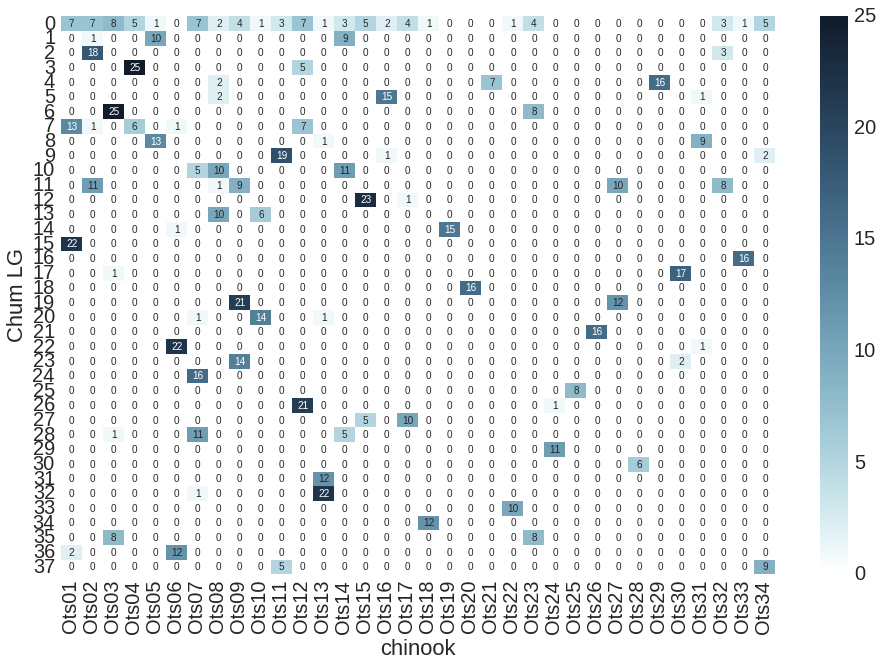

In [146]:
figsize(16,10)
my_colors = sns.cubehelix_palette(n_colors = 6, light=1, start = 2.8, rot = -.1, gamma = 1.2, as_cmap=True)
sns.heatmap(LG_vs_CHR, annot = True, linewidths = 0,square = False, cmap=my_colors, 
           cbar_kws={"orientation": "vertical"})
plt.xlabel('chinook')
plt.show()

In [138]:
chin_ex['Locus_basename'].dtype

dtype('O')

In [139]:
filtered_SAM['RNAME'].dtype

dtype('O')